# Métodos basados en Árboles

Son algoritmos de clasificación supervisada que buscan una variable dependiente completa; las variables dependientes e independientes pueden ser cuantitativas o cualitativas (categóricas). Si su variable dependiente es cuantitativa se utilizan arboles de regresión, si su variable dependiente es cualitativa se utilizan arboles de clasificación.

## Arboles de regresión

In [33]:
import pandas as pd
# Leer un juego de datos de vehiculos usados
vehicles = pd.read_csv('data/used_vehicles.csv')
# visualizar los datos
vehicles

,price,year,miles,doors,type
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car
5,4000,2006,124000,2,car
6,3000,2004,177000,4,car
7,2000,2004,209000,4,truck
8,3000,2003,138000,2,car
9,1900,2003,160000,4,car


In [34]:
# Convertir los datos en el predictor "type" de car a 0 y truck a 1
vehicles['type'] = vehicles.type.map({'car':0, 'truck':1})
# Seleccionamos las columnas a utilizar (todas menos la primera)
feature_cols = vehicles.columns[1:]
# Definimos X (predictores) e y (respuesta)
X = vehicles[feature_cols]
y = vehicles.price
# seperamos los datos en entrenamiento y validación
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Visualizamos cada uno de los arreglos de datos
print(X_train)
print(y_train)
print(X_test)
print(y_test)

    year   miles  doors  type
10  2003  190000      2     1
4   2007   47000      4     0
1   2010   30000      2     0
12  1999  163000      2     1
0   2012   13000      2     0
13  1997  138000      4     0
9   2003  160000      4     0
8   2003  138000      2     0
11  2001   62000      4     0
5   2006  124000      2     0
10     2500
4      9000
1     14000
12     1800
0     22000
13     1300
9      1900
8      3000
11     5000
5      4000
Name: price, dtype: int64
   year   miles  doors  type
3  2009   78000      4     0
7  2004  209000      4     1
6  2004  177000      4     0
2  2010   73500      4     0
3     9500
7     2000
6     3000
2    13000
Name: price, dtype: int64


In [35]:
# Importar la clase o libreria, instanciar el estimador y ajustar el juego de datos de entrenamiento
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [37]:
# Hacer predicciones con los datos de validación
preds = treereg.predict(X_test)
# Visualizar las predicciones y los valores actuales
print(preds)
print(y_test)

[ 5000.  1900.  1900.  5000.]
3     9500
7     2000
6     3000
2    13000
Name: price, dtype: int64


In [38]:
# Revisar el RMSE
from sklearn import metrics
import numpy as np
np.sqrt(metrics.mean_squared_error(y_test, preds))

4622.4993239588475

In [42]:
# Como scikit-learn no permite realizar poda dentro del algoritmo de clasificación
# Es necesario realizar una validación cruzada para encontrar el mejor nivel o 
# máxima profundidad para incluir en el clasificador
from sklearn.cross_validation import cross_val_score

# Manualmente podriamos hacer lo siguiente
# intentamos con max_depth=2
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
#scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
scores = cross_val_score(treereg, X, y, cv=3, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))


4804.3767888427128

In [44]:
# intentamos con max_depth=3
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

4592.1554255755254

In [45]:
# intentamos con max_depth=4
treereg = DecisionTreeRegressor(max_depth=4, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

4704.0052694797387

Como se puede notar, despues del 3er nivel se incrementa el error. Por tanto el mejor sería el 3

In [46]:
# max_depth=3 fue el mejor, asi que ajustamos el arbol usando este parametro para todos los datos
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [47]:
# Computamos la importancia utilizando "Gini" para cada atributo o predictor: 
# la reducción total (normalizada) de los MSE mostrados por predictor
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,type,0.000000


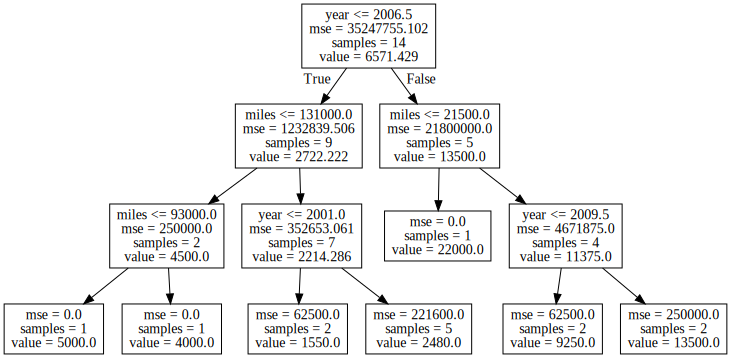

In [58]:
# Creamos el archivo para luego gráficar con "Graphviz"
from sklearn.tree import export_graphviz
with open("g_vehicles.dot", 'wb') as f:
    f = export_graphviz(treereg, out_file="g_vehicles.dot", feature_names=feature_cols)

# Leemos los datos guardados en el paso anterior
with open('g_vehicles.dot') as f:
    dot_g=f.read()
    
# Creamos la gráfica
graphviz.Source(dot_g)

# En la línea de comandos se puede utilizar lo sgte para guardar la gráfica en un archivo, 
# Ejecute esta línea para convertirlo formato PNG:
# dot -Tpng g_vehicles.dot -o g_vehicles.png


### Interpretando el árbol de decisión
Como podemos leer este diagrama?

**Nodos internos**:
- "**samples**": es el numero de observaciones en ese nodo antes de dividirlos
- "**mse**": es el error medio cuadrático calculado de comparar los valores de la respuesta actual en ese nodo contra el valor medio de la respuesta en ese nodo.
- la primera línea es la condición utilizada para dividir ese nodo (vaya a la izquierda si es verdadero o a la derecha si es falso)

**Hojas**:
- "**samples**": es el numero de observaciones que caen en ese nodo
- "**mse**": es el error medio cuadrático calculado de comparar los valores de la respuesta actual en ese nodo contra "value" el valor medio de la respuesta en ese nodo
- "**value**": es el valor medio de la respuesta en ese nodo


### Realizando predicciones sobre nuevos juegos de datos
Cuan preciso es nuestro arbol de regresión creado con scikit-learn para predecir datos nuevos?

In [59]:
# Obtener los datos
#oos = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT4/master/data/used_vehicles_oos.csv')
oos = pd.read_csv('data/used_vehicles_oos.csv')
# convertir car a 0 y truck a 1
oos['type'] = oos.type.map({'car':0, 'truck':1})
# ver los datos
oos

,price,year,miles,doors,type
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [60]:
# definimos X e y
X_oos = oos[feature_cols]
y_oos = oos.price

# hacemos predición sobre los nuevos datos
preds = treereg.predict(X_oos)

# valores actuales y predicciones
print(preds)
print(y_oos.values)

[  4000.   5000.  13500.]
[ 3000  6000 12000]


In [61]:
# Calculamos el RMSE
np.sqrt(metrics.mean_squared_error(y_oos, preds))

1190.2380714238084

In [62]:
# Visualizamos el RMSE para los datos del árbol que se creo inicialmente
your_preds = [4000, 5000, 13500]
np.sqrt(metrics.mean_squared_error(y_oos, your_preds))

1190.2380714238084

## Árboles de Clasificación
Los árboles de clasificación son muy similares a los áboles de regresión, he aquí una breve comparación:

Áboles de regresión | Árboles de clasificación
-- | --
predice una respuesta continua | predice una respuesta categórica
predice usando la respuesta media de cada hoja | predice usando la clase con ocurrencia más común en cada hoja
las divisiones son escogidas minimizando MSE | las divisiones son hechas minimizando un criterio diferente (discutido abajo)


### Criterio de división en los árboles de clasificación 
Aquí algunas de las mas comunes opciones para el criterio de división:

- **rata de error de clasificación**: fracción de las observaciones de entrenamiento en una región que no pertenece a la clase más común.
- **Índice de Gini**: measure of total variance across classes in a region
- **cross-entropy ó entropía-cruzada**: numericamente similar al índice Gini, pero utiliza logaritmos.

Cual utilizar?
- Cuando se crea el árbol, el índice de Gini y cross-entropy son mejores medidas de la "_pureza del nodo_" que la rata de error de clasificación. El índice de Gini es mas rápido computacionalmente que el metodo de cross-entropy, así que es generalmente preferido (y es el utilizado por defecto en scikit-learn)
- Cuando se hace poda del árbol, la rata de error de clasificación es preferible con el fin de máximizar la precisión predictiva.

Por que algunas divisiones resultan en hojas con la misma clase predictora?
- La división fue hecha para incrementar la pureza del nodo, aunque no haya reducido el error de clasificación.
- La pureza del nodo es importante porque nosotros estamos interesados en las proporciones de la clase entre las observaciones en cada región.

## Manipulando predictores categóricos
Algunas implementaciones de los árboles de clasificación permitirán manejar predictores categóricos sin necesidad de crear variables dummy. Cuando se esta dividiendo sobre un predictor categórico, los algoritmos tratarán de dividir sobre cada una de las posibles combinaciónes de las categorías para así encontrar la mejor división.

Desafortunadamente, hasta el momento el algorimo de árbol de clasificación de scikit-learn no soporta este método. En lugar, se debe manipular los predictores categóricos de la siguiente forma:

- Si un predictor solamente tiene dos posibles valores, se códifica como una variable binaria (0 o 1). Como es tratada como numero la división ocurre naturalmente en 0.5
- si un predictor tiene 3 o mas posibles valores que son ordenados u ordinales, se puede codificar como una variable (1, 2, 3, etc.) donde la division ocurrirá naturalmente en 1.5, 2.5, etc.
- Si un predictor tiene 3 o mas predictores que no estan ordenados, se crean variables dummy y se omite el primer nivel como de costumbre. El árbol de decisión no conocerá que las variables dummy estan relacionadas entre sí, pero esto no debería importar en terminos de la precisión predictiva.
- Si un predictor tiene miles de posibles valores desordenados u no ordinales, entonces es mejor codificarlo como una variable simple (1,2,3,etc.) en lugar de usar variables dummy para minimizar el tamaño del modelo resultado.

Veremos a continuación un ejemplo del uso de estas estratégias


### Ejemplo de Árbol de Clasificación
Construiremos un árbol de clasificación utilizando los datos del Titanic provistos por [Kaggle](https://www.kaggle.com/c/titanic-gettingStarted/data).

In [63]:
# Almacenamos los datos
titanic = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT4/master/data/titanic.csv')
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [64]:
# Buscamos por valores faltantes
titanic.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

Escojamos nuestra variable de respuesta y los posibles predictores, y miremos si necesitamos ajustarlos:

- **survived**: Esta sera la variable independiente o respuesta, y ya esta codificada como 0=murió y 1=sobrevivió
- **pclas**: Estas son las categorías de las clases de pasajeros (1=primera clase, 2=segunda clase, 3=tercera clase). Ellas son ordinales, así que las dejaremos como están.
- **sex**: Esta es una categoría binaria, asi que deberiamos codificarla como 0=mujer y 1=hombre.
- **age**: Es una variable con datos nulos que debemos pensar en llenarlos.
- **embarked**: Este es el puerto donde ellos embarcaron. Hay 3 categorías no ordinales, asi que necesitamos crear variables dummy.

In [65]:
# codificamos el atributo o predictor sexo
titanic['sex'] = titanic.sex.map({'female':0, 'male':1})
# llenamos los valores faltantes de edad con el valor medio del mismo predictor
titanic.age.fillna(titanic.age.mean(), inplace=True)
# visualizamos el DataFrame actualizado
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C


In [66]:
# creamos 3 variables dummy utilizando la función "get_dummies" de la librería pandas
pd.get_dummies(titanic.embarked, prefix='embarked').head(10)

,embarked_C,embarked_Q,embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


In [67]:
# creamos entonces las variables dummy, y removemos la primer variable dummy creada, y luego guardamos en el DataFrame
embarked_dummies = pd.get_dummies(titanic.embarked, prefix='embarked').iloc[:, 1:]

# Unimos las 2 columnas de las variables dummy con el DataFrame original
# notar: axis=0 significa filas, axis=1 significa columnas
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# visualizamos el DataFrame actualizado
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,embarked_Q,embarked_S
0,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C,0,0
2,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S,0,1
4,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S,0,1
5,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q,1,0
6,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S,0,1
7,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S,0,1
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S,0,1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C,0,0


In [68]:
# creamos la lista de las columnas o predictore a utilizar en nuestro modelo
feature_cols = ['pclass', 'sex', 'age', 'embarked_Q', 'embarked_S']

# definimos X e y
X = titanic[feature_cols]
y = titanic.survived

# Ajustamos un árbol de clasificación con 3 niveles máximo (max_depth=3) sobre todos los datos
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

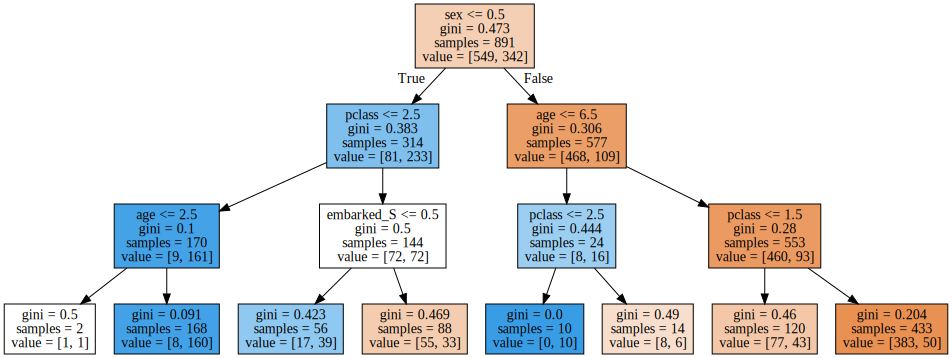

In [77]:
# creamos el archivo Graphviz
# with open("15_titanic.dot", 'wb') as f:
#     f = export_graphviz(treeclf, out_file=f, feature_names=feature_cols)
    
# Exportamos los datos del arbol a un archivo
export_graphviz(treeclf,out_file='titanic.dot', feature_names=feature_cols, impurity=True, filled=True)

# Leemos los datos guardados en el paso anterior
with open('titanic.dot') as f:
    dot_graph=f.read()

# Creamos la gráfica a partir de los datos anteriores
graphviz.Source(dot_graph)

Note que la división en la parte inferior derecha, fue hecha solamente para incrementar la pureza del nodo.

In [78]:
# computar la importancia de los predictores
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,pclass,0.242664
1,sex,0.655584
2,age,0.064494
3,embarked_Q,0.000000
4,embarked_S,0.037258


### Otro ejemplo de Arboles de Clasificación con los datos de la base de datos IRIS

In [9]:
# Cargamos las respectivas librerías a utilizar
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.cross_validation import train_test_split
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
import numpy as np

In [81]:
# Cargamos los datos de iris o flores.
iris=load_iris()
# Separamos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)
# Creamos y ajustamos el arbol
arbol = DecisionTreeClassifier()
arbol.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [82]:
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
arbol.score(X_train,y_train) # Como puede verse, esta sobreajustado

1.0

In [83]:
arbol.score(X_test,y_test)

0.92105263157894735

In [84]:
# Exportamos los datos del arbol a un archivo
export_graphviz(arbol,out_file='arbol.dot',class_names=iris.target_names, 
                feature_names=iris.feature_names, impurity=False, filled=True, rounded=True,)

# Leemos los datos guardados en el paso anterior
with open('arbol.dot') as f:
    dot_graph=f.read()

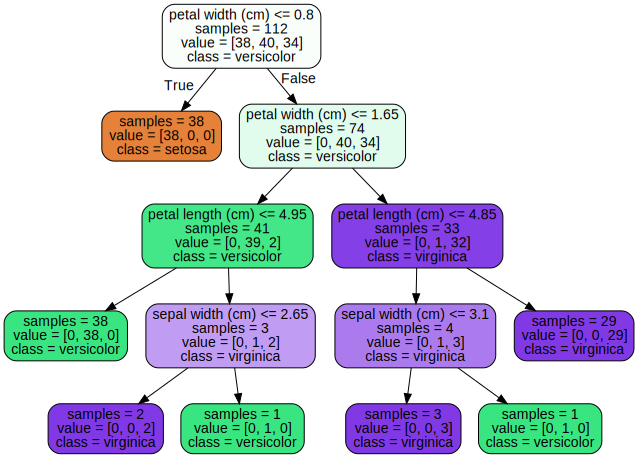

In [85]:
# Creamos la gráfica a partir de los datos anteriores
graphviz.Source(dot_graph)

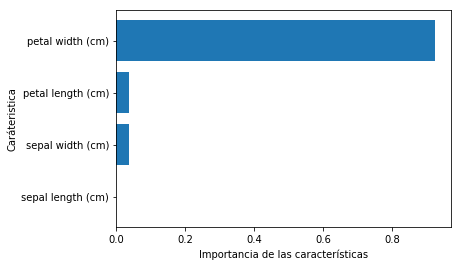

In [86]:
caract=iris.data.shape[1]
plt.barh(range(caract),arbol.feature_importances_)
plt.yticks(np.arange(caract),iris.feature_names)
plt.xlabel("Importancia de las características")
plt.ylabel("Caráteristica")
plt.show()

In [88]:
# Creamos un nuevo arbol con 3 niveles para mejorar el ajuste del modelo
arbol = DecisionTreeClassifier(max_depth=3).fit(X_train,y_train)
arbol.score(X_train,y_train) # Como puede verse, ya no esta sobreajustado aunque no deja mucho para que la maquina aprenda

0.9821428571428571

In [89]:
arbol.score(X_test,y_test)

0.97368421052631582

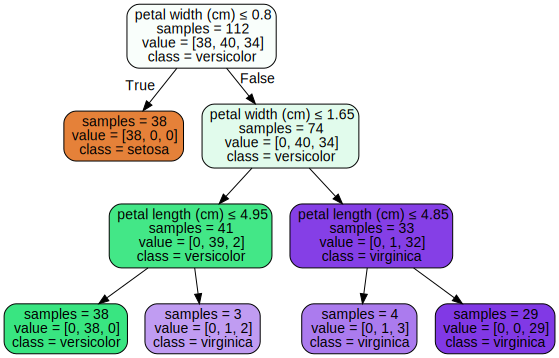

In [91]:
# Exportamos los datos del arbol a un archivo
export_graphviz(arbol,out_file='arbol2.dot',class_names=iris.target_names, 
                feature_names=iris.feature_names, impurity=False, filled=True, rounded=True, special_characters=True)

# Leemos los datos guardados en el paso anterior
with open('arbol2.dot') as f:
    dot_graph=f.read()

graphviz.Source(dot_graph)

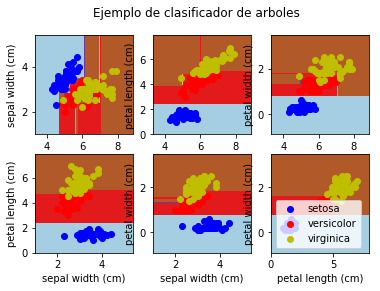

In [26]:
# Graficamos de nuevo para ver nuestra precision del modelo, o como clasificó nuestros datos
# Inicialmente todos los niveles
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

for pairidx, pair in enumerate([[0,1],[0,2],[0,3], [1,2],[1,3],[2,3]]):
    X = iris.data[:, pair]
    y = iris.target
    #Entrenamos el modelo
    clf = DecisionTreeClassifier().fit(X,y)
    # Gráficamos
    plt.subplot(2,3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx,0], X[idx, 1], c=color, label=iris.target_names[i], cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Ejemplo de clasificador de arboles")
plt.legend()
plt.show()


Se obervan las líneas rojas donde representan que nuestros datos estan sobre ajustados.

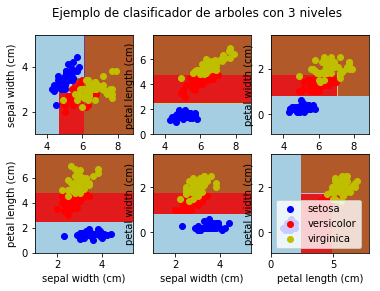

In [29]:
# Gráficamos de nuevo sin sobreajuste con un max nivel de 3
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

for pairidx, pair in enumerate([[0,1],[0,2],[0,3], [1,2],[1,3],[2,3]]):
    X = iris.data[:, pair]
    y = iris.target
    #Entrenamos el modelo
    clf = DecisionTreeClassifier(max_depth=3).fit(X,y)
    # Gráficamos
    plt.subplot(2,3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx,0], X[idx, 1], c=color, label=iris.target_names[i], cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Ejemplo de clasificador de arboles con 3 niveles")
plt.legend()
plt.show()


## Ejemplo de Clasificación utilizando los datos de Aduanas
Aquí se muestra otro ejemplo presentado en el diplomado de Data mining de la Universidad del Valle en el 2017.
Este ejercicio fue realizado tanto manualmente utilizando un conjunto pequeño de los datos como automático utilizando el software [WEKA](https://www.cs.waikato.ac.nz/ml/weka/), dirigido por el Prof. Poggi

Parametros basicos utilizados en WEKA

=== Run information ===

Scheme:       weka.classifiers.trees.J48 -C 0.25 -M 2<br>
Relation:     datos_impo_train<br>
Instances:    4354<br>
Attributes:   16<br>
              PERIODO_OFICIALIZACION<br>
              SUBREGIMEN<br>
              REGION_ORIGEN<br>
              PAIS_ORIGEN_DESC<br>
              REGION_PROCEDENCIA<br>
              PAIS_PROCEDENCIA_DESC<br>
              MEDIO_TRANSPORTE_DESC<br>
              ADUANA_DESC<br>
              REGION_ADUANA<br>
              UNIDAD_DESC<br>
              CAPITULO<br>
              PARTIDA<br>
              CANTIDAD_UNIDAD<br>
              KILOS_NETOS<br>
              MONTO_FOB_DOLAR<br>
              CANAL<br>
Test mode:    10-fold cross-validation<br>

![weka](./assets/weka.png)

In [239]:
# Para el ejercicio manual, se utilizo el siguiente conjunto de Datos
aduanas = pd.read_csv('data/aduanas_small.csv', encoding="UTF-8")
aduanas

,id,grupo,aduana,transportista,importador,origen,procedencia,fiscalizacion
0,1,electrónicos,San Javier,1,4,py,br,ilicito
1,2,juguetes,San Javier,1,4,py,br,ilicito
2,3,juguetes,San Javier,1,4,py,cn,ilicito
3,4,juguetes,San Javier,1,4,py,cn,ilicito
4,5,juguetes,T5,4,2,cn,cn,ilicito
5,6,juguetes,T5,2,2,cn,cn,ok
6,7,juguetes,T5,2,2,cn,cn,ok
7,8,juguetes,T5,2,2,py,cn,ilicito
8,9,juguetes,Posadas,3,2,br,cn,ilicito
9,10,juguetes,T5,4,2,cn,cn,ilicito


### Problema
Al inspector de turno en la Aduana de San Javier se le avisa que van a arribar al mismo tiempo 3 camiones con mercadería para ingresar al país. Sólo tiene capacidad para fiscalizar a uno solo y debe dejar pasar a los otros 2.

Los embarques que están por arribar tienen las siguientes características:											
- **A**: Declaró transportar electrónicos de origen chino, procede de Paraguay, el transportista es  3, el importador 4 y el despachante 65.											
- **B**: El transportista 3 declaró traer libros de origen y procedencia brasileños. El importador es el 4 y el despachante el 81.											
- **C**: El transportista 2 declaró juguetes mexicanos. El importador es el 4 y el despachante el 82.				


1. Si cuenta con la evidencia que consta más abajo, a cuál de los 3 embarques le recomendaría que fiscalizara, asumiendo que su éxito depende de encontrar alguna irregularidad en el embarque?
2. Que pasa si en el caso C el transportista es el 1.									

In [240]:
# Resvisamos las variables cualitativas y cuantitativas, transformando estas últimas 
# en númericas para poder procesarlas en el modelo
aduanas.describe()

,id,transportista,importador
count,40.000000,40.000000,40.000000
mean,20.500000,3.325000,2.500000
std,11.690452,1.670061,1.300887
min,1.000000,1.000000,1.000000
25%,10.750000,2.000000,1.000000
50%,20.500000,3.000000,2.000000
75%,30.250000,5.000000,4.000000
max,40.000000,6.000000,4.000000


In [241]:
# Variables posibles en el predictor grupo
aduanas.grupo.unique()

array(['electrónicos', 'juguetes', 'autos'], dtype=object)

In [242]:
# Variables posibles en el predictor aduana
list(aduanas.aduana.unique())

['San Javier', 'T5', 'Posadas', 'EZE']

In [243]:
# Variables posibles en el predictor origen
aduanas.origen.unique()

array(['py', 'cn', 'br', 'mx'], dtype=object)

In [244]:
# Variables posibles en el predictor procedencia
list(aduanas.procedencia.unique())

['br', 'cn', 'mx']

In [245]:
# Variables posibles en el predictor fiscalizacion
list(aduanas.fiscalizacion.unique())

['ilicito', 'ok']

In [246]:
# Procedemos a crear variables binarias y dummy para estos predictores categóricos
# Como nuestra variable respuesta es la fiscalización y es de tipo binaria, procedemos así
# codificamos el atributo o predictor sexo
aduanas['fiscalizacion'] = aduanas.fiscalizacion.map({'ilicito':0, 'ok':1})

# Para el caso del resto de predictores categóricos, procedemos a crear variables dummy, 
# debido a que todos tienen mas de dos posibles valores
grupo_dummies = pd.get_dummies(aduanas.grupo, prefix='grupo').iloc[:, 1:]
aduana_dummies = pd.get_dummies(aduanas.aduana, prefix='aduana').iloc[:, 1:]
origen_dummies = pd.get_dummies(aduanas.origen, prefix='origen').iloc[:, 1:]
procedencia_dummies = pd.get_dummies(aduanas.procedencia, prefix='procedencia').iloc[:, 1:]

# Unimos las variables con el DataFrame original
aduanas_clean = pd.concat([aduanas, grupo_dummies, aduana_dummies, origen_dummies, procedencia_dummies], axis=1)
# visualizamos el DataFrame actualizado
aduanas_clean.head(10)

,id,grupo,aduana,transportista,importador,origen,procedencia,fiscalizacion,grupo_electrónicos,grupo_juguetes,aduana_Posadas,aduana_San Javier,aduana_T5,origen_cn,origen_mx,origen_py,procedencia_cn,procedencia_mx
0,1,electrónicos,San Javier,1,4,py,br,0,1,0,0,1,0,0,0,1,0,0
1,2,juguetes,San Javier,1,4,py,br,0,0,1,0,1,0,0,0,1,0,0
2,3,juguetes,San Javier,1,4,py,cn,0,0,1,0,1,0,0,0,1,1,0
3,4,juguetes,San Javier,1,4,py,cn,0,0,1,0,1,0,0,0,1,1,0
4,5,juguetes,T5,4,2,cn,cn,0,0,1,0,0,1,1,0,0,1,0
5,6,juguetes,T5,2,2,cn,cn,1,0,1,0,0,1,1,0,0,1,0
6,7,juguetes,T5,2,2,cn,cn,1,0,1,0,0,1,1,0,0,1,0
7,8,juguetes,T5,2,2,py,cn,0,0,1,0,0,1,0,0,1,1,0
8,9,juguetes,Posadas,3,2,br,cn,0,0,1,1,0,0,0,0,0,1,0
9,10,juguetes,T5,4,2,cn,cn,0,0,1,0,0,1,1,0,0,1,0


In [247]:
# creamos la lista de las columnas o predictores a utilizar en nuestro modelo
feature_cols = ['grupo_electrónicos', 'grupo_juguetes', 'aduana_Posadas','aduana_San Javier','aduana_T5', 'transportista', 'importador', 
                'origen_cn','origen_mx','origen_py', 'procedencia_cn','procedencia_mx']

aduanas.target_names = ["ilícito", "ok"]

# definimos X e y
X = aduanas_clean[feature_cols]
y = aduanas_clean.fiscalizacion

# Ajustamos un árbol de clasificación con 3 niveles máximo (max_depth=3) sobre todos los datos
# from sklearn.tree import DecisionTreeClassifier
# treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [248]:
treeclf.score(X, y)

0.92500000000000004

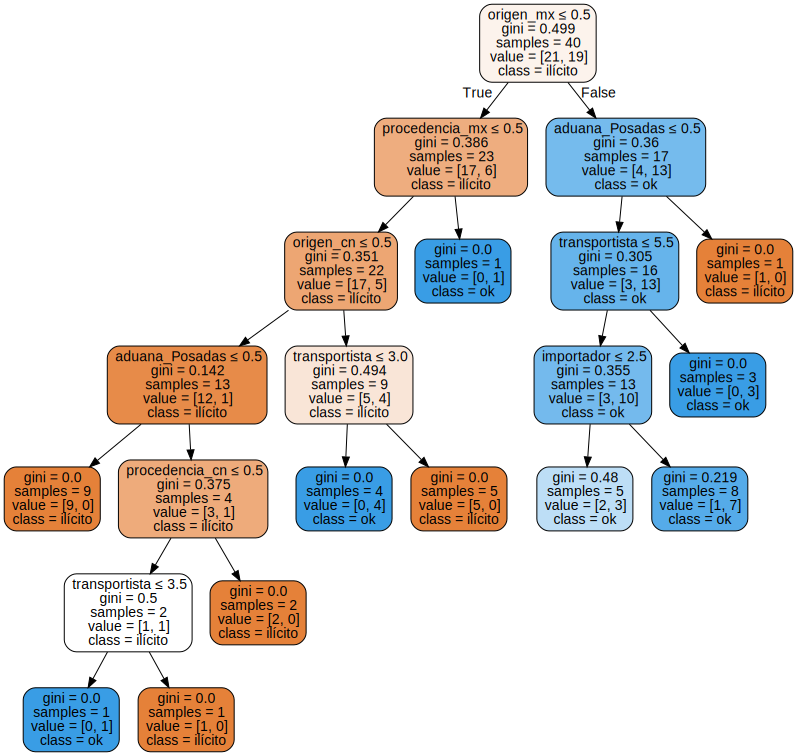

In [249]:
# Exportamos los datos del arbol a un archivo
export_graphviz(treeclf,out_file='aduanas_small.dot', class_names=aduanas.target_names, 
                feature_names=feature_cols, impurity=True, filled=True, rounded=True, special_characters=True)

# Leemos los datos guardados en el paso anterior
with open('aduanas_small.dot') as f:
    dot_graph=f.read()

# Creamos la gráfica a partir de los datos anteriores
graphviz.Source(dot_graph)

In [250]:
# computar la importancia de los predictores
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,grupo_electrónicos,0.000000
1,grupo_juguetes,0.000000
2,aduana_Posadas,0.100557
3,aduana_San Javier,0.000000
4,aduana_T5,0.000000
5,transportista,0.361016
6,importador,0.029455
7,origen_cn,0.090929
8,origen_mx,0.314100
9,origen_py,0.000000


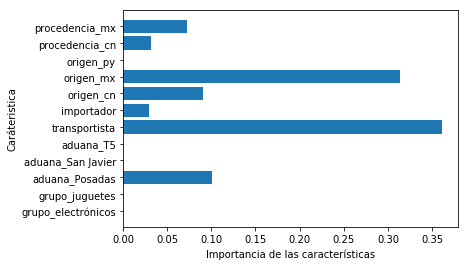

In [251]:
caract=len(feature_cols)
plt.barh(range(caract),treeclf.feature_importances_)
plt.yticks(np.arange(caract),feature_cols)
plt.xlabel("Importancia de las características")
plt.ylabel("Caráteristica")
plt.show()

In [252]:
# Ahora trataremos de predecir algunos valores nuevos
# La variable despachante no fue incluida en los datos impresos.

#list(X.columns.values)

#A: Declaró transportar electrónicos de origen chino, procede de Paraguay, el transportista es 3, 
#   el importador 4 y el despachante 65.
#B: El transportista 3 declaró traer libros de origen y procedencia brasileños. El importador es el 4 
#   y el despachante el 81.
#C: El transportista 2 declaró juguetes mexicanos. El importador es el 4 y el despachante el 82.

aduana_small_test_A = [{'grupo_electrónicos':1,'grupo_juguetes':0,'aduana_Posadas':0,'aduana_San Javier':1,
                        'aduana_T5':0,'transportista':3,'importador':4,'origen_cn':1,'origen_mx':0,'origen_py':0,
                        'procedencia_cn':0,'procedencia_mx':0}]

aduana_small_test_B = [{'grupo_electrónicos':0,'grupo_juguetes':0,'aduana_Posadas':0,'aduana_San Javier':1,
                        'aduana_T5':0,'transportista':3,'importador':4,'origen_cn':0,'origen_mx':0,'origen_py':0,
                        'procedencia_cn':0,'procedencia_mx':0}]

aduana_small_test_C = [{'grupo_electrónicos':0,'grupo_juguetes':1,'aduana_Posadas':0,'aduana_San Javier':1,
                        'aduana_T5':0,'transportista':2,'importador':4,'origen_cn':0,'origen_mx':1,'origen_py':0,
                        'procedencia_cn':0,'procedencia_mx':1}]


aduana_small_test = [{'grupo_electrónicos':1,'grupo_juguetes':0,'aduana_Posadas':0,'aduana_San Javier':0,
                        'aduana_T5':0,'transportista':3,'importador':4,'origen_cn':1,'origen_mx':0,'origen_py':0,
                        'procedencia_cn':0,'procedencia_mx':0},
                       {'grupo_electrónicos':0,'grupo_juguetes':0,'aduana_Posadas':0,'aduana_San Javier':0,
                        'aduana_T5':0,'transportista':3,'importador':4,'origen_cn':0,'origen_mx':0,'origen_py':0,
                        'procedencia_cn':0,'procedencia_mx':0},
                       {'grupo_electrónicos':0,'grupo_juguetes':1,'aduana_Posadas':0,'aduana_San Javier':0,
                        'aduana_T5':0,'transportista':2,'importador':4,'origen_cn':0,'origen_mx':1,'origen_py':0,
                        'procedencia_cn':0,'procedencia_mx':1},
                       {'grupo_electrónicos':0,'grupo_juguetes':1,'aduana_Posadas':0,'aduana_San Javier':0,
                        'aduana_T5':0,'transportista':1,'importador':4,'origen_cn':0,'origen_mx':1,'origen_py':0,
                        'procedencia_cn':0,'procedencia_mx':1}]

X_test = pd.DataFrame(aduana_small_test)
X_test

,aduana_Posadas,aduana_San Javier,aduana_T5,grupo_electrónicos,grupo_juguetes,importador,origen_cn,origen_mx,origen_py,procedencia_cn,procedencia_mx,transportista
0,0,0,0,1,0,4,1,0,0,0,0,3
1,0,0,0,0,0,4,0,0,0,0,0,3
2,0,0,0,0,1,4,0,1,0,0,1,2
3,0,0,0,0,1,4,0,1,0,0,1,1


In [253]:
preds = treeclf.predict(X_test)
# valores actuales y predicciones
print(preds)

[1 1 1 1]


Según la respuesta, todos los embarques estarían "ok"; y no tendriamos un criterio claro de cual no dejar pasar para revisar. Es necesario agregar o remover variables, y ajustar los parametros del clasificador para obtener una mejor respuesta. Concluimos entonces que no hay evidencia suficiente para clasificar estos embarques en ilícitos o lícitos.

### Ejemplo con R

``` R
# Decision Trees with Customs data
library(tree)
aduanas = read.csv("/Users/ernestogiron/Desktop/DiplomadoUnivalle_DS2017/statistical_learning/ISLR/data/aduanas_small.csv", header = TRUE, sep = ",", dec = ".", encoding = "cp1252")
names(aduanas)
head(aduanas)
tree.aduanas=tree(fiscalizacion~.-id,data = aduanas)
summary(tree.aduanas)
plot(tree.aduanas)
text(tree.aduanas,pretty=0)
tree.aduanas
```
![aduanasR_DT](./assets/aduanasR_DT.png)

``` R
# Validamos contra un juego de datos extraido de los datos de entrenamiento, debido a que no tenemos más
set.seed(2)
train=sample(1:nrow(aduanas), 30)
aduanas.test=aduanas[-train,] # Solo 10 observaciones de las 40
head(aduanas.test)
Fiscalizacion.test=aduanas$fiscalizacion[-train]
head(Fiscalizacion.test)
tree.aduanas=tree(fiscalizacion~.-id, aduanas, subset=train)
tree.pred=predict(tree.aduanas, aduanas.test, type="class")
table(tree.pred,Fiscalizacion.test)
(3+3)/10

# Realizamos poda y validamos el modelo
set.seed(3)
cv.aduanas=cv.tree(tree.aduanas,FUN=prune.misclass)
names(cv.aduanas)
cv.aduanas
# Gráficamos
par(mfrow=c(1,2))
plot(cv.aduanas\$size,cv.aduanas\$dev,type="b")
plot(cv.aduanas\$k,cv.aduanas\$dev,type="b")
prune.aduanas=prune.misclass(tree.aduanas,best=2)
plot(prune.aduanas)
text(prune.aduanas,pretty=0)
tree.pred=predict(prune.aduanas,aduanas.test,type="class")
table(tree.pred,Fiscalizacion.test)
(7+3)/10
```

![aduanasR_DT](./assets/aduanasR_DT1.png)

``` R
# De nuevo podamos
prune.aduanas=prune.misclass(tree.aduanas,best=4)
plot(prune.aduanas)
text(prune.aduanas,pretty=0)
tree.pred=predict(prune.aduanas,aduanas.test,type="class")
table(tree.pred,Fiscalizacion.test)
(7+3)/10

```
![aduanasR_DT2](./assets/aduanasR_DT2.png)

### Predecimos algunas observaciónes nuevas

```R
# Validamos los ejemplos A,B,C del ejercicio

#A: Declaró transportar electrónicos de origen chino, procede de Paraguay, el transportista es 3, 
#   el importador 4 y el despachante 65.
#B: El transportista 3 declaró traer libros de origen y procedencia brasileños. El importador es el 4 
#   y el despachante el 81.
#C: El transportista 2 declaró juguetes mexicanos. El importador es el 4 y el despachante el 82.

embarque_A = data.frame(id=1, grupo="electronicos", aduana="San Javier", transportista=3, importador=4, origen="cn", procedencia="py",fiscalizacion=NA)
embarque_B = data.frame(id=2, grupo="libros", aduana="San Javier", transportista=3, importador=4, origen="br", procedencia="br",fiscalizacion=NA)
embarque_C = data.frame(id=3, grupo="juguetes", aduana="San Javier", transportista=2, importador=4, origen="mx", procedencia="mx",fiscalizacion=NA)

embarques <- rbind(embarque_A, embarque_B, embarque_C)
rm(embarque_A, embarque_B, embarque_C)
embarques = data.frame(embarques)
transform(embarques, id=as.numeric(id), transportista=as.numeric(transportista), importador=as.numeric(importador))
head(embarques)

tree.pred=predict(tree.aduanas,embarques,type="class")
tree.pred # Utilizando todo el árbol sin poda, tenemos que el embarque B podría ser ilícito
tree.pred1=predict(prune.aduanas,embarques,type="class")
tree.pred1 # Utilizando el árbol podado, observamos que todos son "ok", por tanto no hay un criterio claro para detener el embarque

```

### VEAMOS EL MISMO EJEMPLO UTILIZANDO OTRAS LIBRERIAS

``` R
# =============================================================
# Paso 1: Cargar librerias y juego de datos o dataset
# -------------------------------------------------------------
#install.packages("rpart.plot")
#install.packages("C50")
library(rpart)
library(rpart.plot)
library(C50)

# Paso 2: Preparar juego de datos o dataset
# -------------------------------------------------------------
aduanas_data <- aduanas[,-1] # todos los atributos menos el "id"
head(aduanas_data)

# Paso 3: Creamos juego de datos de entrenamiento y validacion
# -------------------------------------------------------------
# Dividimos el dataset en 60% entreno y 40% validación
ind <- sample(2,nrow(aduanas_data),replace = TRUE,prob = c(0.6, 0.4))
trainData <- aduanas_data[ind==1,] 
testData <- aduanas_data[ind==2,]

# Paso 4: Creamos el Árbol de decisión
# -------------------------------------------------------------
arbolRpart <- rpart(fiscalizacion ~., method = "class", data = trainData)

# Paso 5: Revisamos información y Gráficamos
# -------------------------------------------------------------
print(arbolRpart)
par(mfrow=c(1, 1))
rpart.plot(arbolRpart, extra = 4) # extra=4 probabilidad de observaciones por clase

# Paso 6: Revisamos estadisticas y gráfico de error por número de nodos
# -------------------------------------------------------------
printcp(arbolRpart) # estadisticas de resultados
plotcp(arbolRpart) # Evolución del error a medida que se incrementan los nodos

# Paso 7: Poda del Árbol
# -------------------------------------------------------------
pArbolRpart <- prune(arbolRpart,cp=arbolRpart$cptable[which.min(arbolRpart$cptable[,"xerror"]),"CP"])
#pArbolRpart <- prune(arbolRpart,cp=0.011111)
printcp(pArbolRpart)

# Paso 8: Predecir las fiscalizaciones de testData
# -------------------------------------------------------------
# Validamos la capacidad de predicción del árbol con los datos de validación
testPredRPart <- predict(arbolRpart, newdata = testData, type = "class")
# visualizamos una matriz de confusión
table(testPredRPart, testData$fiscalizacion)
# Validamos con el árbol podado (No hay diferencia)
testPredRPart2 <- predict(pArbolRpart, newdata = testData, type = "class")
# visualizamos una matriz de confusión
table(testPredRPart2, testData$fiscalizacion)

# Paso 8: Estadística del modelo
# -------------------------------------------------------------
# Calculamos el % de aciertos
sum(testPredRPart == testData$fiscalizacion) / length(testData$fiscalizacion) * 100

```

### Ahora realizaremos un ejercicio similar pero con mayor evidencia o un conjunto de datos mas grande de 4354 observaciones y 17 variables.

In [177]:
# Cargamos los datos de aduanas
# Estos datos se cargaron en R con la librería "foreign" y exportados a CSV para utilizarlos aquí
# library(foreign)
# Aduanas_train = read.arff("/Users/ernestogiron/Desktop/DiplomadoUnivalle_DS2017/MachineLearning/WEKA/curso_datos_aduana_train.arff")
# Aduanas_test = read.arff("/Users/ernestogiron/Desktop/DiplomadoUnivalle_DS2017/MachineLearning/WEKA/curso_datos_aduana_test.arff")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

aduanas_train = pd.read_csv('data/aduanas_train.csv')
aduanas_test = pd.read_csv('data/aduanas_test.csv')
aduanas_train.head(10)

,Unnamed: 0,PERIODO_OFICIALIZACION,SUBREGIMEN,REGION_ORIGEN,PAIS_ORIGEN_DESC,REGION_PROCEDENCIA,PAIS_PROCEDENCIA_DESC,MEDIO_TRANSPORTE_DESC,ADUANA_DESC,REGION_ADUANA,UNIDAD_DESC,CAPITULO,PARTIDA,CANTIDAD_UNIDAD,KILOS_NETOS,MONTO_FOB_DOLAR,CANAL
0,1,201701,IC04,NaN,ESTADOS_UNIDOS,NaN,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8523.0,89201.0,1096.89,478780.1,R
1,2,201703,IC04,NaN,ESTADOS_UNIDOS,NaN,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8517.0,18.0,196.51,68617.6,N
2,3,201702,IC04,NaN,ESTADOS_UNIDOS,NaN,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8543.0,82354.0,1526.67,527666.97,R
3,4,201701,IC04,NaN,ESTADOS_UNIDOS,NaN,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8501.0,25.0,197.12,56710.52,N
4,5,201701,IC04,NaN,MEXICO,NaN,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8517.0,649.0,7565.14,1617791.33,N
5,6,201703,IC04,NaN,ESTADOS_UNIDOS,NaN,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8523.0,921.0,162.13,74209.86,N
6,7,201703,IC04,UE,REP_FED_DE_ALEMANIA,UE,REP_FED_DE_ALEMANIA,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8517.0,288.0,1147.73,854567.87,R
7,8,201701,IC04,CN,CHINA,CN,CHINA,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8504.0,263287.0,3478.12,113961,R
8,9,201702,IC04,CN,CHINA,NaN,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8504.0,13701.0,2379.10,240925.9,R
9,10,201703,IC04,XX,MALASIA,NaN,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8517.0,2122.0,8922.54,1535972.17,R


In [178]:
aduanas_train.shape

(4354, 17)

In [179]:
# Buscamos por valores faltantes
aduanas_train.isnull().sum()

Unnamed: 0                   0
PERIODO_OFICIALIZACION       0
SUBREGIMEN                   0
REGION_ORIGEN              659
PAIS_ORIGEN_DESC             0
REGION_PROCEDENCIA         984
PAIS_PROCEDENCIA_DESC        0
MEDIO_TRANSPORTE_DESC        0
ADUANA_DESC                  0
REGION_ADUANA                0
UNIDAD_DESC                  0
CAPITULO                     0
PARTIDA                      0
CANTIDAD_UNIDAD              0
KILOS_NETOS                  0
MONTO_FOB_DOLAR              0
CANAL                     1028
dtype: int64

In [180]:
aduanas_train.CANAL.unique()

array(['R', 'N', 'V', nan], dtype=object)

In [181]:
# llenamos los valores faltantes de REGION_ORIGEN y  REGION_PROCEDENCIA con el valor NA
aduanas_train.REGION_ORIGEN.fillna('NA', inplace=True)
aduanas_train.REGION_PROCEDENCIA.fillna('NA', inplace=True)

aduanas_train.CANAL.fillna('RNV', inplace=True)
# codificamos el atributo o predictor CANAL
aduanas_train['CANAL'] = aduanas_train.CANAL.map({'R':0, 'N':1, 'V':2, 'RNV':3})

# removemos la primer columna
aduanas_train = aduanas_train.iloc[:, 1:]

# visualizamos el DataFrame actualizado
aduanas_train.head(10)

,PERIODO_OFICIALIZACION,SUBREGIMEN,REGION_ORIGEN,PAIS_ORIGEN_DESC,REGION_PROCEDENCIA,PAIS_PROCEDENCIA_DESC,MEDIO_TRANSPORTE_DESC,ADUANA_DESC,REGION_ADUANA,UNIDAD_DESC,CAPITULO,PARTIDA,CANTIDAD_UNIDAD,KILOS_NETOS,MONTO_FOB_DOLAR,CANAL
0,201701,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8523.0,89201.0,1096.89,478780.1,0
1,201703,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8517.0,18.0,196.51,68617.6,1
2,201702,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8543.0,82354.0,1526.67,527666.97,0
3,201701,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8501.0,25.0,197.12,56710.52,1
4,201701,IC04,NA,MEXICO,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8517.0,649.0,7565.14,1617791.33,1
5,201703,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8523.0,921.0,162.13,74209.86,1
6,201703,IC04,UE,REP_FED_DE_ALEMANIA,UE,REP_FED_DE_ALEMANIA,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8517.0,288.0,1147.73,854567.87,0
7,201701,IC04,CN,CHINA,CN,CHINA,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8504.0,263287.0,3478.12,113961,0
8,201702,IC04,CN,CHINA,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8504.0,13701.0,2379.10,240925.9,0
9,201703,IC04,XX,MALASIA,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,85,8517.0,2122.0,8922.54,1535972.17,0


In [182]:
aduanas_train.describe()

,PERIODO_OFICIALIZACION,CAPITULO,PARTIDA,CANTIDAD_UNIDAD,KILOS_NETOS,CANAL
count,4354.000000,4354.000000,4.354000e+03,4.354000e+03,4.354000e+03,4354.000000
mean,201702.040652,2085.610932,3.091082e+04,5.621552e+04,2.231752e+05,1.314653
std,0.837854,3598.908755,2.053079e+05,3.691407e+05,1.401441e+06,1.180565
min,201701.000000,82.000000,1.300000e-01,2.000000e-02,5.000000e-02,0.000000
25%,201701.000000,85.000000,8.504000e+03,3.901600e+02,1.783562e+03,0.000000
50%,201702.000000,85.000000,8.528000e+03,3.120085e+03,1.137962e+04,1.000000
75%,201703.000000,87.000000,8.706000e+03,1.627174e+04,6.912382e+04,2.000000
max,201703.000000,8903.000000,8.044705e+06,9.608897e+06,3.676378e+07,3.000000


In [183]:
aduanas_train.columns.values

array(['PERIODO_OFICIALIZACION', 'SUBREGIMEN', 'REGION_ORIGEN',
       'PAIS_ORIGEN_DESC', 'REGION_PROCEDENCIA', 'PAIS_PROCEDENCIA_DESC',
       'MEDIO_TRANSPORTE_DESC', 'ADUANA_DESC', 'REGION_ADUANA',
       'UNIDAD_DESC', 'CAPITULO', 'PARTIDA', 'CANTIDAD_UNIDAD',
       'KILOS_NETOS', 'MONTO_FOB_DOLAR', 'CANAL'], dtype=object)

In [184]:
# Revisamos el numero de posibles valores que toma cada predictor categórico 
# con el fin de procesar la variable como binaria o creando variables dummy o eliminandola si es el caso
list(aduanas_train.PERIODO_OFICIALIZACION.unique())

[201701, 201703, 201702]

In [185]:
list(aduanas_train.SUBREGIMEN.unique())

['IC04',
 'IC05',
 'IC03',
 'IC99',
 'IG03',
 'IG04',
 'IG05',
 'IC33',
 'IC34',
 'IC01',
 'IC24',
 'IG07',
 'IC31',
 'IC35']

In [186]:
list(aduanas_train.REGION_ORIGEN.unique())

['NA', 'UE', 'CN', 'XX', 'MS', 'IN']

In [187]:
list(aduanas_train.PAIS_ORIGEN_DESC.unique())

['ESTADOS_UNIDOS',
 'MEXICO',
 'REP_FED_DE_ALEMANIA',
 'CHINA',
 'MALASIA',
 'TAILANDIA',
 'FILIPINAS',
 'VIETNAM',
 'CANADA',
 'TAIWAN',
 'ITALIA',
 'REINO_UNIDO',
 'JAPON',
 'BRASIL',
 'COREA_REPUBLICANA',
 'ESPANA',
 'INDIA',
 'FRANCIA',
 'RUMANIA',
 'REP_CHECA',
 'PAISES_BAJOS',
 'URUGUAY',
 'HUNGRIA',
 'SUECIA',
 'CHILE',
 'AUSTRIA',
 'POLONIA',
 'INDONESIA']

In [188]:
list(aduanas_train.REGION_PROCEDENCIA.unique())

['NA', 'UE', 'CN', 'XX', 'MS', 'IN']

In [189]:
list(aduanas_train.PAIS_PROCEDENCIA_DESC.unique())

['ESTADOS_UNIDOS',
 'REP_FED_DE_ALEMANIA',
 'CHINA',
 'FRANCIA',
 'REINO_UNIDO',
 'VIETNAM',
 'BRASIL',
 'PAISES_BAJOS',
 'TAIWAN',
 'MEXICO',
 'COREA_REPUBLICANA',
 'ITALIA',
 'TAILANDIA',
 'ESPANA',
 'INDIA',
 'JAPON',
 'URUGUAY',
 'BELGICA',
 'CHILE',
 'SINGAPUR']

In [190]:
list(aduanas_train.MEDIO_TRANSPORTE_DESC.unique())

['AVION', 'CAMION', 'ACUATICO', 'PROPIOS_MEDIOS']

In [191]:
list(aduanas_train.ADUANA_DESC.unique())

['EZEIZA',
 'CORDOBA',
 'BSAS',
 'USHUAIA',
 'RIO_GRANDE',
 'CAMPANA',
 'SANTA_FE',
 'VILLA_CONSTITUCION',
 'PASO_DE_LOS_LIBRES',
 'ROSARIO',
 'SANTO_TOME',
 'SAN_NICOLAS',
 'MENDOZA',
 'PUERTO_MADRYN',
 'BARILOCHE']

In [192]:
list(aduanas_train.REGION_ADUANA.unique())

['DIRECCION_ADUANA_DE_EZEIZA',
 'DIR_REG_AD_CENTRAL',
 'DIR_ADUANA_DE_BUENOS_AIRES',
 'DIR_REG_AD_PATAG,UNIDAD"',
 'SUB_GRAL_DE_OP_ADUNERAS_MET',
 'DIR_REG_AD_HIDROV,UNIDAD"',
 'DIR_REG_AD_PAMPEANA',
 'DIR_REG_AD_PATAG,KILOGRAMO"',
 'DIR_REG_AD_HIDROV,KILOGRAMO"']

In [193]:
# Corregimos algunos valores que a simple vista se notan que estan errados
aduanas_train.REGION_ADUANA.replace('DIR_REG_AD_PATAG,UNIDAD"','DIR_REG_AD_PATAG', inplace=True)
aduanas_train.REGION_ADUANA.replace('DIR_REG_AD_HIDROV,UNIDAD"','DIR_REG_AD_HIDROV', inplace=True)
aduanas_train.REGION_ADUANA.replace('DIR_REG_AD_PATAG,KILOGRAMO"','DIR_REG_AD_PATAG', inplace=True)
aduanas_train.REGION_ADUANA.replace('DIR_REG_AD_HIDROV,KILOGRAMO"','DIR_REG_AD_HIDROV', inplace=True)

In [194]:
list(aduanas_train.REGION_ADUANA.unique())

['DIRECCION_ADUANA_DE_EZEIZA',
 'DIR_REG_AD_CENTRAL',
 'DIR_ADUANA_DE_BUENOS_AIRES',
 'DIR_REG_AD_PATAG',
 'SUB_GRAL_DE_OP_ADUNERAS_MET',
 'DIR_REG_AD_HIDROV',
 'DIR_REG_AD_PAMPEANA']

In [195]:
list(aduanas_train.UNIDAD_DESC.unique())

['UNIDAD', '85', '87', '88', 'KILOGRAMO', '82', '83', '86', '89']

In [196]:
list(aduanas_train.CAPITULO.unique())

[85,
 82,
 87,
 8541,
 8518,
 8517,
 8504,
 8507,
 8542,
 8501,
 8704,
 86,
 89,
 8543,
 8526,
 8703,
 8516,
 8711,
 8802,
 8706,
 8707,
 8511,
 8714,
 8702,
 83,
 88,
 8533,
 8529,
 8536,
 8544,
 8534,
 8532,
 8537,
 8708,
 8522,
 8204,
 8309,
 8201,
 8716,
 8207,
 8302,
 8503,
 8305,
 8208,
 8540,
 8502,
 8523,
 8701,
 8512,
 8525,
 8510,
 8531,
 8515,
 8545,
 8514,
 8215,
 8211,
 8521,
 8538,
 8803,
 8602,
 8712,
 8205,
 8546,
 8715,
 8203,
 8535,
 8903,
 8301,
 8609]

Algunas de las variables no se tendran en cuenta como lo son las numericas (**KILOS_NETOS, MONTO_FOB_DOLAR**), que deberian redefinirse en rangos (_mas adelante veremos si son necesarias incluirlas en nuestro modelo_); y algunas como **UNIDAD_DESC, CAPITULO** que no ofrecen mucha información para nuestro model.

In [197]:
# Como se observa, las únicas variables númericas son CAPITULO, PARTIDA, CANTIDAD_UNIDAD, KILOS_NETOS y CANAL
# Por lo que debemos crear variables dummy para el resto que estandarizar o normalizar las númericas

# Escogemos las columnas o predictores que deseamos para el modelo
# "PERIODO_OFICIALIZACION","SUBREGIMEN", "REGION_ORIGEN", "PAIS_ORIGEN_DESC", "REGION_PROCEDENCIA", "PAIS_PROCEDENCIA_DESC",
# "MEDIO_TRANSPORTE_DESC", "ADUANA_DESC", "REGION_ADUANA", "UNIDAD_DESC", "CAPITULO", "PARTIDA", "CANTIDAD_UNIDAD",
# "KILOS_NETOS", "MONTO_FOB_DOLAR", "CANAL"

predictores = ["PERIODO_OFICIALIZACION","SUBREGIMEN", "REGION_ORIGEN", "REGION_PROCEDENCIA","MEDIO_TRANSPORTE_DESC", 
               "ADUANA_DESC", "REGION_ADUANA"]

# Para el caso del resto de predictores categóricos, procedemos a crear variables dummy, 
# debido a que todos tienen mas de dos posibles valores
periodo_oficializacion_dummies = pd.get_dummies(aduanas_train.PERIODO_OFICIALIZACION, prefix='PERIODO_OFICIALIZACION').iloc[:, 1:]
subregimen_dummies = pd.get_dummies(aduanas_train.SUBREGIMEN, prefix='SUBREGIMEN').iloc[:, 1:]
region_origen_dummies = pd.get_dummies(aduanas_train.REGION_ORIGEN, prefix='REGION_ORIGEN').iloc[:, 1:]
region_procedencia_dummies = pd.get_dummies(aduanas_train.REGION_PROCEDENCIA, prefix='REGION_PROCEDENCIA').iloc[:, 1:]
medio_transporte_desc_dummies = pd.get_dummies(aduanas_train.MEDIO_TRANSPORTE_DESC, prefix='MEDIO_TRANSPORTE_DESC').iloc[:, 1:]
aduana_desc_dummies = pd.get_dummies(aduanas_train.ADUANA_DESC, prefix='ADUANA_DESC').iloc[:, 1:]
region_aduana_dummies = pd.get_dummies(aduanas_train.REGION_ADUANA, prefix='REGION_ADUANA').iloc[:, 1:]

# Unimos las variables con el DataFrame original
aduanas_ = pd.concat([aduanas_train, periodo_oficializacion_dummies, subregimen_dummies, region_origen_dummies, 
                           region_procedencia_dummies, medio_transporte_desc_dummies, aduana_desc_dummies, 
                           region_aduana_dummies], axis=1)
# visualizamos el DataFrame actualizado
aduanas_.head(10)

,PERIODO_OFICIALIZACION,SUBREGIMEN,REGION_ORIGEN,PAIS_ORIGEN_DESC,REGION_PROCEDENCIA,PAIS_PROCEDENCIA_DESC,MEDIO_TRANSPORTE_DESC,ADUANA_DESC,REGION_ADUANA,UNIDAD_DESC,...,ADUANA_DESC_SANTO_TOME,ADUANA_DESC_SAN_NICOLAS,ADUANA_DESC_USHUAIA,ADUANA_DESC_VILLA_CONSTITUCION,REGION_ADUANA_DIR_ADUANA_DE_BUENOS_AIRES,REGION_ADUANA_DIR_REG_AD_CENTRAL,REGION_ADUANA_DIR_REG_AD_HIDROV,REGION_ADUANA_DIR_REG_AD_PAMPEANA,REGION_ADUANA_DIR_REG_AD_PATAG,REGION_ADUANA_SUB_GRAL_DE_OP_ADUNERAS_MET
0,201701,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
1,201703,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
2,201702,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
3,201701,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
4,201701,IC04,NA,MEXICO,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
5,201703,IC04,NA,ESTADOS_UNIDOS,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
6,201703,IC04,UE,REP_FED_DE_ALEMANIA,UE,REP_FED_DE_ALEMANIA,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
7,201701,IC04,CN,CHINA,CN,CHINA,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
8,201702,IC04,CN,CHINA,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
9,201703,IC04,XX,MALASIA,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0


In [198]:
list(aduanas_)

['PERIODO_OFICIALIZACION',
 'SUBREGIMEN',
 'REGION_ORIGEN',
 'PAIS_ORIGEN_DESC',
 'REGION_PROCEDENCIA',
 'PAIS_PROCEDENCIA_DESC',
 'MEDIO_TRANSPORTE_DESC',
 'ADUANA_DESC',
 'REGION_ADUANA',
 'UNIDAD_DESC',
 'CAPITULO',
 'PARTIDA',
 'CANTIDAD_UNIDAD',
 'KILOS_NETOS',
 'MONTO_FOB_DOLAR',
 'CANAL',
 'PERIODO_OFICIALIZACION_201702',
 'PERIODO_OFICIALIZACION_201703',
 'SUBREGIMEN_IC03',
 'SUBREGIMEN_IC04',
 'SUBREGIMEN_IC05',
 'SUBREGIMEN_IC24',
 'SUBREGIMEN_IC31',
 'SUBREGIMEN_IC33',
 'SUBREGIMEN_IC34',
 'SUBREGIMEN_IC35',
 'SUBREGIMEN_IC99',
 'SUBREGIMEN_IG03',
 'SUBREGIMEN_IG04',
 'SUBREGIMEN_IG05',
 'SUBREGIMEN_IG07',
 'REGION_ORIGEN_IN',
 'REGION_ORIGEN_MS',
 'REGION_ORIGEN_NA',
 'REGION_ORIGEN_UE',
 'REGION_ORIGEN_XX',
 'REGION_PROCEDENCIA_IN',
 'REGION_PROCEDENCIA_MS',
 'REGION_PROCEDENCIA_NA',
 'REGION_PROCEDENCIA_UE',
 'REGION_PROCEDENCIA_XX',
 'MEDIO_TRANSPORTE_DESC_AVION',
 'MEDIO_TRANSPORTE_DESC_CAMION',
 'MEDIO_TRANSPORTE_DESC_PROPIOS_MEDIOS',
 'ADUANA_DESC_BSAS',
 'ADUANA_DESC

In [199]:
predictores_cols = ['PERIODO_OFICIALIZACION_201702', 'PERIODO_OFICIALIZACION_201703', 'SUBREGIMEN_IC03', 
                    'SUBREGIMEN_IC04','SUBREGIMEN_IC05','SUBREGIMEN_IC24','SUBREGIMEN_IC31',
                    'SUBREGIMEN_IC33','SUBREGIMEN_IC34','SUBREGIMEN_IC35','SUBREGIMEN_IC99','SUBREGIMEN_IG03',
                    'SUBREGIMEN_IG04','SUBREGIMEN_IG05','SUBREGIMEN_IG07','REGION_ORIGEN_IN',
                    'REGION_ORIGEN_MS','REGION_ORIGEN_NA','REGION_ORIGEN_UE','REGION_ORIGEN_XX',
                    'REGION_PROCEDENCIA_IN','REGION_PROCEDENCIA_MS','REGION_PROCEDENCIA_NA','REGION_PROCEDENCIA_UE',
                    'REGION_PROCEDENCIA_XX','MEDIO_TRANSPORTE_DESC_AVION','MEDIO_TRANSPORTE_DESC_CAMION',
                    'MEDIO_TRANSPORTE_DESC_PROPIOS_MEDIOS','ADUANA_DESC_BSAS','ADUANA_DESC_CAMPANA',
                    'ADUANA_DESC_CORDOBA','ADUANA_DESC_EZEIZA','ADUANA_DESC_MENDOZA','ADUANA_DESC_PASO_DE_LOS_LIBRES',
                    'ADUANA_DESC_PUERTO_MADRYN','ADUANA_DESC_RIO_GRANDE','ADUANA_DESC_ROSARIO','ADUANA_DESC_SANTA_FE',
                    'ADUANA_DESC_SANTO_TOME','ADUANA_DESC_SAN_NICOLAS','ADUANA_DESC_USHUAIA',
                    'ADUANA_DESC_VILLA_CONSTITUCION','REGION_ADUANA_DIR_ADUANA_DE_BUENOS_AIRES',
                    'REGION_ADUANA_DIR_REG_AD_CENTRAL','REGION_ADUANA_DIR_REG_AD_HIDROV',
                    'REGION_ADUANA_DIR_REG_AD_HIDROV','REGION_ADUANA_DIR_REG_AD_PAMPEANA',
                    'REGION_ADUANA_DIR_REG_AD_PATAG','REGION_ADUANA_DIR_REG_AD_PATAG',
                    'REGION_ADUANA_SUB_GRAL_DE_OP_ADUNERAS_MET']

# definimos X e y
X = aduanas_[predictores_cols]
y = aduanas_.CANAL

# Ajustamos un árbol de clasificación sobre todos los datos
treeclf2 = DecisionTreeClassifier(random_state=1)
treeclf2.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [200]:
treeclf2.score(X, y)

0.65457050987597609

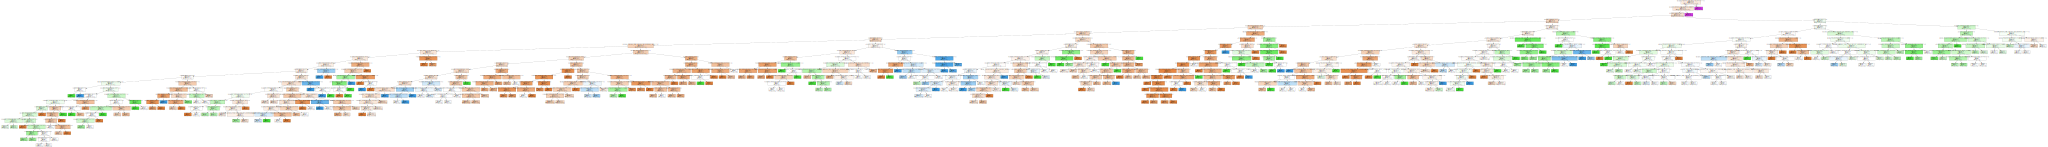

In [201]:
# Exportamos los datos del arbol a un archivo
export_graphviz(treeclf2,out_file='aduanas_full.dot', feature_names=predictores_cols, impurity=True, filled=True)
# Leemos los datos guardados en el paso anterior
with open('aduanas_full.dot') as f:
    dot_graph=f.read()

    # Creamos la gráfica a partir de los datos anteriores
graphviz.Source(dot_graph)

In [202]:
# computar la importancia de los predictores
pd.DataFrame({'feature':predictores_cols, 'importance':treeclf2.feature_importances_})

,feature,importance
0,PERIODO_OFICIALIZACION_201702,0.026020
1,PERIODO_OFICIALIZACION_201703,0.024483
2,SUBREGIMEN_IC03,0.002757
3,SUBREGIMEN_IC04,0.006216
4,SUBREGIMEN_IC05,0.008944
5,SUBREGIMEN_IC24,0.006713
6,SUBREGIMEN_IC31,0.000000
7,SUBREGIMEN_IC33,0.000000
8,SUBREGIMEN_IC34,0.000397
9,SUBREGIMEN_IC35,0.000000


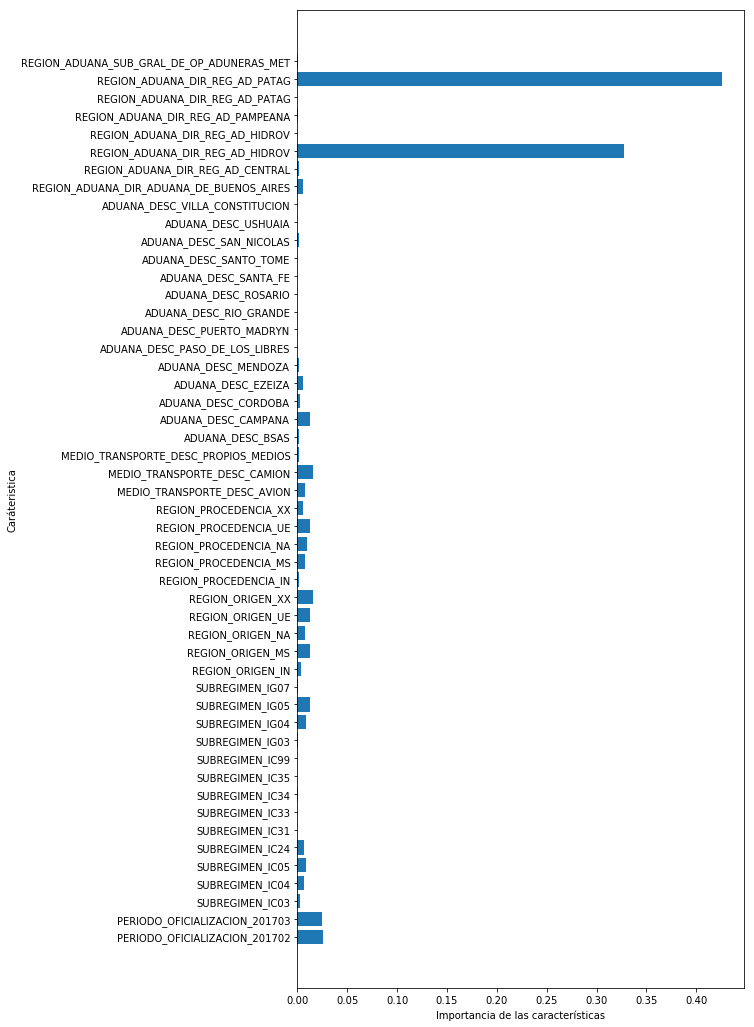

In [203]:
caract=len(predictores_cols)
plt.figure(figsize=(8,18))
plt.barh(range(caract),treeclf2.feature_importances_)
plt.yticks(np.arange(caract),predictores_cols)
plt.xlabel("Importancia de las características")
plt.ylabel("Caráteristica")
plt.show()

In [204]:
predictores_cols = ['PERIODO_OFICIALIZACION_201702', 'PERIODO_OFICIALIZACION_201703','REGION_ORIGEN_IN',
                    'REGION_ORIGEN_MS','REGION_ORIGEN_NA','REGION_ORIGEN_UE','REGION_ORIGEN_XX',
                    'REGION_PROCEDENCIA_IN','REGION_PROCEDENCIA_MS','REGION_PROCEDENCIA_NA','REGION_PROCEDENCIA_UE',
                    'REGION_PROCEDENCIA_XX','MEDIO_TRANSPORTE_DESC_AVION','MEDIO_TRANSPORTE_DESC_CAMION',
                    'MEDIO_TRANSPORTE_DESC_PROPIOS_MEDIOS','REGION_ADUANA_DIR_ADUANA_DE_BUENOS_AIRES',
                    'REGION_ADUANA_DIR_REG_AD_CENTRAL','REGION_ADUANA_DIR_REG_AD_HIDROV',
                    'REGION_ADUANA_DIR_REG_AD_HIDROV','REGION_ADUANA_DIR_REG_AD_PAMPEANA',
                    'REGION_ADUANA_DIR_REG_AD_PATAG','REGION_ADUANA_DIR_REG_AD_PATAG',
                    'REGION_ADUANA_SUB_GRAL_DE_OP_ADUNERAS_MET']

respuesta_names = ['R','N','V','RNV']

# definimos X e y
X = aduanas_[predictores_cols]
y = aduanas_.CANAL

# Ajustamos un árbol de clasificación sobre todos los datos
treeclf2 = DecisionTreeClassifier(max_depth=10, random_state=1)
treeclf2.fit(X, y)
treeclf2.score(X, y)

0.61368856224161694

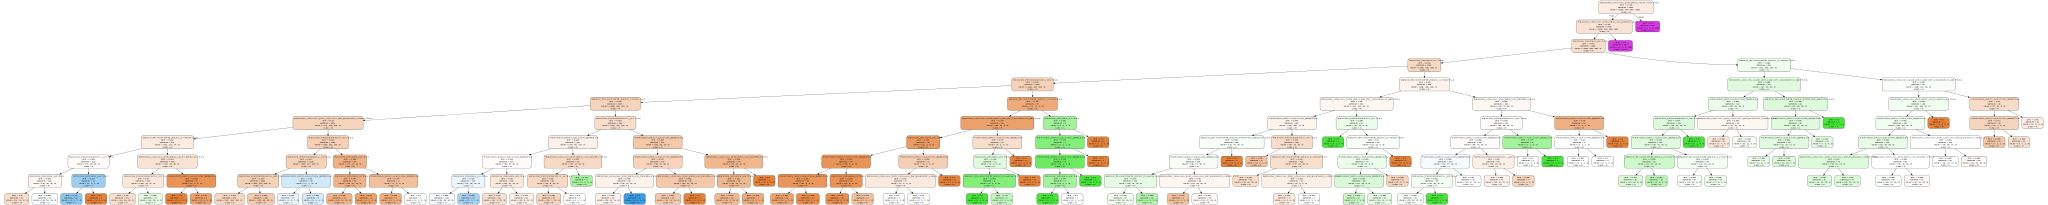

In [205]:
# Exportamos los datos del arbol a un archivo
export_graphviz(treeclf2,out_file='aduanas_full2.dot', feature_names=predictores_cols,  class_names=respuesta_names, 
                impurity=True, filled=True, rounded=True, special_characters=True)

# Leemos los datos guardados en el paso anterior
with open('aduanas_full2.dot') as f:
    dot_graph=f.read()

    # Creamos la gráfica a partir de los datos anteriores
graphviz.Source(dot_graph)

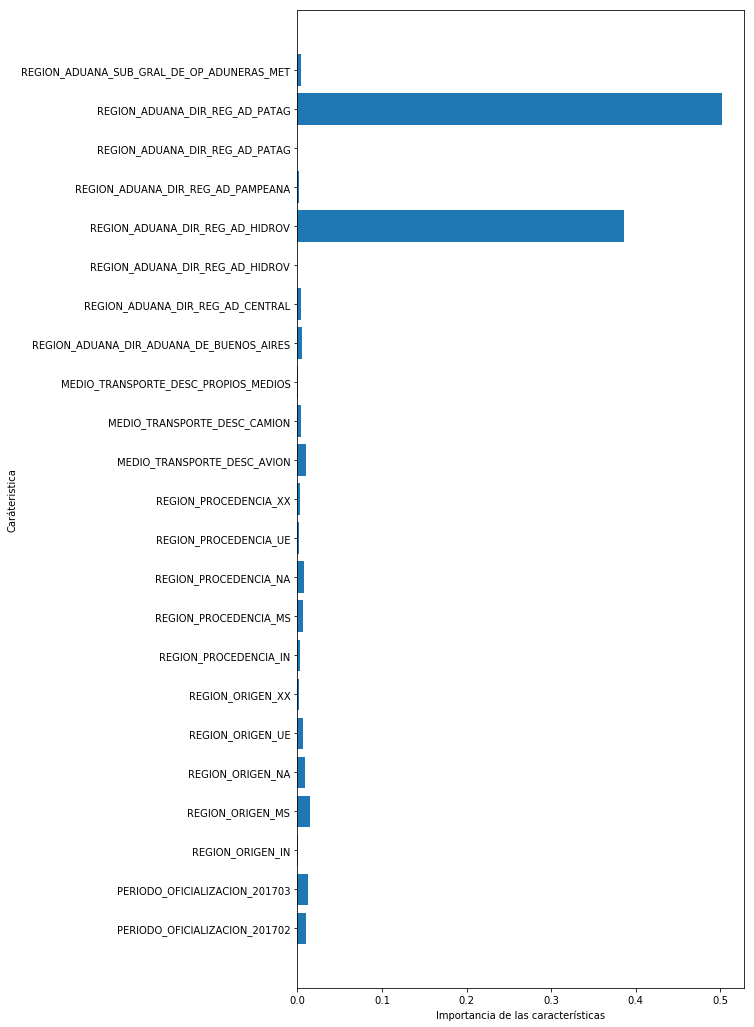

In [206]:
caract=len(predictores_cols)
plt.figure(figsize=(8,18))
plt.barh(range(caract),treeclf2.feature_importances_)
plt.yticks(np.arange(caract),predictores_cols)
plt.xlabel("Importancia de las características")
plt.ylabel("Caráteristica")
plt.show()

In [207]:
# Predicción
# Para poder realizar la predicción necesitamos depurar los datos de validación de la misma forma que se realizó
# con los datos de entrenamiento, en lo posible, eliminando el mayor número de inconsistencias

# Buscamos por valores faltantes
aduanas_test.isnull().sum()

Unnamed: 0                 0
PERIODO_OFICIALIZACION     0
SUBREGIMEN                 0
REGION_ORIGEN             20
PAIS_ORIGEN_DESC           0
REGION_PROCEDENCIA        33
PAIS_PROCEDENCIA_DESC      0
MEDIO_TRANSPORTE_DESC      0
ADUANA_DESC                0
REGION_ADUANA              0
UNIDAD_DESC                0
CAPITULO                   0
PARTIDA                    0
CANTIDAD_UNIDAD            0
KILOS_NETOS                0
MONTO_FOB_DOLAR            0
CANAL                     34
dtype: int64

In [208]:
# llenamos los valores faltantes de REGION_ORIGEN y  REGION_PROCEDENCIA con el valor NA
aduanas_test.REGION_ORIGEN.fillna('NA', inplace=True)
aduanas_test.REGION_PROCEDENCIA.fillna('NA', inplace=True)

aduanas_test.CANAL.fillna('RNV', inplace=True)
# codificamos el atributo o predictor CANAL
aduanas_test['CANAL'] = aduanas_test.CANAL.map({'R':0, 'N':1, 'V':2, 'RNV':3})

# removemos la primer columna
aduanas_test = aduanas_test.iloc[:, 1:]


# Corregimos algunos valores que a simple vista se notan que estan errados
aduanas_test.REGION_ADUANA.replace('DIR_REG_AD_PATAG,UNIDAD"','DIR_REG_AD_PATAG', inplace=True)
aduanas_test.REGION_ADUANA.replace('DIR_REG_AD_HIDROV,UNIDAD"','DIR_REG_AD_HIDROV', inplace=True)
aduanas_test.REGION_ADUANA.replace('DIR_REG_AD_PATAG,KILOGRAMO"','DIR_REG_AD_PATAG', inplace=True)
aduanas_test.REGION_ADUANA.replace('DIR_REG_AD_HIDROV,KILOGRAMO"','DIR_REG_AD_HIDROV', inplace=True)


# Para el caso del resto de predictores categóricos, procedemos a crear variables dummy, 
# debido a que todos tienen mas de dos posibles valores
periodo_oficializacion_dummies = pd.get_dummies(aduanas_test.PERIODO_OFICIALIZACION, prefix='PERIODO_OFICIALIZACION').iloc[:, 1:]
subregimen_dummies = pd.get_dummies(aduanas_test.SUBREGIMEN, prefix='SUBREGIMEN').iloc[:, 1:]
region_origen_dummies = pd.get_dummies(aduanas_test.REGION_ORIGEN, prefix='REGION_ORIGEN').iloc[:, 1:]
region_procedencia_dummies = pd.get_dummies(aduanas_test.REGION_PROCEDENCIA, prefix='REGION_PROCEDENCIA').iloc[:, 1:]
medio_transporte_desc_dummies = pd.get_dummies(aduanas_test.MEDIO_TRANSPORTE_DESC, prefix='MEDIO_TRANSPORTE_DESC').iloc[:, 1:]
aduana_desc_dummies = pd.get_dummies(aduanas_test.ADUANA_DESC, prefix='ADUANA_DESC').iloc[:, 1:]
region_aduana_dummies = pd.get_dummies(aduanas_test.REGION_ADUANA, prefix='REGION_ADUANA').iloc[:, 1:]

# Unimos las variables con el DataFrame original
aduanasTest_ = pd.concat([aduanas_test, periodo_oficializacion_dummies, subregimen_dummies, region_origen_dummies, 
                           region_procedencia_dummies, medio_transporte_desc_dummies, aduana_desc_dummies, 
                           region_aduana_dummies], axis=1)
# visualizamos el DataFrame actualizado
aduanasTest_.head(10)

,PERIODO_OFICIALIZACION,SUBREGIMEN,REGION_ORIGEN,PAIS_ORIGEN_DESC,REGION_PROCEDENCIA,PAIS_PROCEDENCIA_DESC,MEDIO_TRANSPORTE_DESC,ADUANA_DESC,REGION_ADUANA,UNIDAD_DESC,...,ADUANA_DESC_SANTA_FE,ADUANA_DESC_SANTO_TOME,ADUANA_DESC_SAN_NICOLAS,ADUANA_DESC_USHUAIA,REGION_ADUANA_DIR_ADUANA_DE_BUENOS_AIRES,REGION_ADUANA_DIR_REG_AD_CENTRAL,REGION_ADUANA_DIR_REG_AD_HIDROV,REGION_ADUANA_DIR_REG_AD_PAMPEANA,REGION_ADUANA_DIR_REG_AD_PATAG,REGION_ADUANA_SUB_GRAL_DE_OP_ADUNERAS_MET
0,201702,IC05,MS,BRASIL,MS,BRASIL,CAMION,PASO_DE_LOS_LIBRES,DIR_REG_AD_HIDROV,87,...,0,0,0,0,0,0,1,0,0,0
1,201703,IC05,CN,CHINA,CN,CHINA,CAMION,RIO_GRANDE,DIR_REG_AD_PATAG,85,...,0,0,0,0,0,0,0,0,1,0
2,201702,IC04,NA,MEXICO,NA,MEXICO,ACUATICO,BSAS,DIR_ADUANA_DE_BUENOS_AIRES,UNIDAD,...,0,0,0,0,1,0,0,0,0,0
3,201701,IC04,CN,CHINA,CN,CHINA,ACUATICO,CAMPANA,SUB_GRAL_DE_OP_ADUNERAS_MET,UNIDAD,...,0,0,0,0,0,0,0,0,0,1
4,201701,IC04,CN,CHINA,CN,CHINA,ACUATICO,ROSARIO,DIR_REG_AD_HIDROV,87,...,0,0,0,0,0,0,1,0,0,0
5,201703,IC04,XX,TAILANDIA,NA,ESTADOS_UNIDOS,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
6,201703,IC04,IN,INDIA,IN,INDIA,ACUATICO,BSAS,DIR_ADUANA_DE_BUENOS_AIRES,KILOGRAMO,...,0,0,0,0,1,0,0,0,0,0
7,201703,IC04,CN,CHINA,CN,CHINA,AVION,EZEIZA,DIRECCION_ADUANA_DE_EZEIZA,UNIDAD,...,0,0,0,0,0,0,0,0,0,0
8,201703,IG04,UE,REP_FED_DE_ALEMANIA,UE,REP_FED_DE_ALEMANIA,ACUATICO,BSAS,DIR_ADUANA_DE_BUENOS_AIRES,UNIDAD,...,0,0,0,0,1,0,0,0,0,0
9,201701,IC05,MS,BRASIL,MS,BRASIL,CAMION,ROSARIO,DIR_REG_AD_HIDROV,83,...,0,0,0,0,0,0,1,0,0,0


In [209]:
predictores_cols = ['PERIODO_OFICIALIZACION_201702', 'PERIODO_OFICIALIZACION_201703','REGION_ORIGEN_IN',
                    'REGION_ORIGEN_MS','REGION_ORIGEN_NA','REGION_ORIGEN_UE','REGION_ORIGEN_XX',
                    'REGION_PROCEDENCIA_IN','REGION_PROCEDENCIA_MS','REGION_PROCEDENCIA_NA','REGION_PROCEDENCIA_UE',
                    'REGION_PROCEDENCIA_XX','MEDIO_TRANSPORTE_DESC_AVION','MEDIO_TRANSPORTE_DESC_CAMION',
                    'MEDIO_TRANSPORTE_DESC_PROPIOS_MEDIOS','REGION_ADUANA_DIR_ADUANA_DE_BUENOS_AIRES',
                    'REGION_ADUANA_DIR_REG_AD_CENTRAL','REGION_ADUANA_DIR_REG_AD_HIDROV',
                    'REGION_ADUANA_DIR_REG_AD_HIDROV','REGION_ADUANA_DIR_REG_AD_PAMPEANA',
                    'REGION_ADUANA_DIR_REG_AD_PATAG','REGION_ADUANA_DIR_REG_AD_PATAG',
                    'REGION_ADUANA_SUB_GRAL_DE_OP_ADUNERAS_MET']

respuesta_names = ['R','N','V','RNV']

# definimos X e y
X_test = aduanasTest_[predictores_cols]
y_test = aduanasTest_.CANAL

# Ajustamos un árbol de clasificación sobre todos los datos
treeclf2.predict(X_test)

array([3, 3, 0, 0, 3, 0, 2, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 2, 0, 1, 0, 0,
       0, 1, 1, 0, 3, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 3, 3, 3, 0, 0,
       3, 0, 1, 2, 3, 0, 1, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 2, 3,
       2, 0, 3, 3, 0, 0, 0, 0, 3, 2, 0, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 1, 3,
       1, 1, 0, 0, 1, 0, 0, 0, 3, 3, 1, 0, 3, 2, 3, 3, 3, 0, 0, 1, 3, 0, 0,
       3, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 2, 1, 2, 0, 2, 0, 0, 0, 0, 1,
       1, 0, 0, 3, 3, 2, 1, 0, 3, 0, 0, 2, 3, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0,
       0, 0, 2])

In [210]:
treeclf2.score(X_test, y_test)

0.51829268292682928

### Determinando donde o cuando podar
Debido a que scikit-learn no posee funciones como las de R (printcp, plotcp, etc) para determinar el error, ni tampoco tiene una funcione como prune de rpart de R (_ver ejemplo al final del notebook_); entonces debemos realizar la comprobación manual.

Para ello creamos una funcion que cree varios árboles de decisición con diferentes niveles y comprobamos el error o precisión.

In [211]:
levels = [1,3,5,7,9,11,13,15,17,19,21,23]
X = aduanas_[predictores_cols]
y = aduanas_.CANAL
X_test = aduanasTest_[predictores_cols]
y_test = aduanasTest_.CANAL

def runTrees():
    for i in levels:
        # Ajustamos un árbol de clasificación sobre todos los datos
        clf = DecisionTreeClassifier(max_depth=i, random_state=1)
        clf.fit(X, y)
        #clf.predict(X_test)
        ypred = clf.predict(X_test)
        k_accs.append(accuracy_score(y_test, ypred))
        print("Nivel",i , end='')
        print(" %.4f" %clf.score(X, y), end='')
        print(" %.4f" %clf.score(X_test, y_test))

runTrees()

Nivel 1 0.5016 0.4207
Nivel 3 0.5958 0.5488
Nivel 5 0.5974 0.5488
Nivel 7 0.6011 0.5366
Nivel 9 0.6112 0.5183
Nivel 11 0.6151 0.5122
Nivel 13 0.6226 0.5366
Nivel 15 0.6254 0.5183
Nivel 17 0.6256 0.5183
Nivel 19 0.6256 0.5183
Nivel 21 0.6256 0.5183
Nivel 23 0.6256 0.5183


Como se puede observar la precisión de nuestro modelo no mejora en los datos de entrenamiento con más de 17 niveles, y confrontandolos con los datos de validación o prueba, con 5 niveles es mas preciso que con 17.

Pruning can reduce overfitting. Scikit-Learn DecisionTree classifier does not support pruning currently, but one can set the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem. Here we will use cross validation with different max depths to optimize the tree.

In [214]:
from sklearn.cross_validation import KFold
#from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
#from sklearn.metrics import mean_squared_error
#from IPython.display import Image

Xr, Xt, yr, yt = train_test_split(X, y, train_size=3048, test_size=1306, random_state=42)
Xr.shape[0]
print(Xr.values.shape)

(3048, 23)


You're running into the different conventions for Pandas DataFrame indexing versus NumPy ndarray indexing. The arrays train_index and test_index are collections of row indices. But data is a Pandas DataFrame object, and when you use a single index into that object, as in data[train_index], Pandas is expecting train_index to contain column labels rather than row indices. You can either convert the dataframe to a NumPy array, using .values:

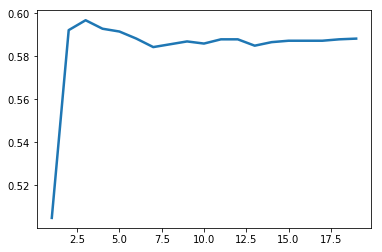

In [218]:
kfold = KFold(Xr.shape[0], n_folds=10)
# Convert DataFrame to Numpy array to avoid index error
#Xr = Xr.values
#yr = yr.values
#kfold = KFold(n_splits=10) # sklearn.model_selection
#kfold.get_n_splits(Xr)
accs = []
max_depths = range(1, 20)
for max_depth in max_depths:
    k_accs = []
    #for train, test in kfold.split(Xr): # sklearn.model_selection
    for train, test in kfold:
        Xtrain, Xtest, ytrain, ytest = Xr.iloc[train], Xr.iloc[test], yr.iloc[train], yr.iloc[test]
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))
    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth
plt.plot(max_depths, accs, linewidth=2.5)
plt.show()

El menor valor para el parámetro max_depth para el cual la precisión alcanza un pico es alrededor de 3. Entonces ahora evaluaremos el mejor árbol desde la validación cruzada contra nuestro juego de datos de validación.

In [220]:
from sklearn.metrics import confusion_matrix
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(Xr, yr)
ypred = clf.predict(Xt)
confusion_matrix(yt, ypred), accuracy_score(yt, ypred)

(array([[410,  49,   0,   0],
        [219,  65,   0,   0],
        [209,  54,   0,   0],
        [  0,   0,   0, 300]]), 0.59341500765696786)

Para mejorar un poco el ánalisis y no hacer pruebas de este tipo (tratar de buscar los mejores predictores y combinaciones de variables junto con el nivel adecuado, etc...) que a menudo son muy desgastantes, se recomienda utilizar un metodo emsanble bastante conocido llamado "**Random Forest**" que veremos en la próxima sección.

## Aquí la misma solución pero en R

```R
# Decision Trees with Customs data
library(tree)
#install.packages("foreign")
library(foreign)
Aduanas_train = read.arff("/Users/ernestogiron/Desktop/DiplomadoUnivalle_DS2017/MachineLearning/WEKA/curso_datos_aduana_train.arff")
Aduanas_test = read.arff("/Users/ernestogiron/Desktop/DiplomadoUnivalle_DS2017/MachineLearning/WEKA/curso_datos_aduana_test.arff")

names(Aduanas_train)
head(Aduanas_train)

# Seleccionamos las variables representativas a usar en el modelo
# Quitamos de nuestros predictores las variables con valores numericos con alta variabilidad
Aduanas_train = Aduanas_train[c(2,3,5,7,8,11,16)]
Aduanas_test = Aduanas_test[c(2,3,5,7,8,11,16)]
names(Aduanas_train)
# Creamos el árbol
tree.aduanas=tree(CANAL~.,Aduanas_train)
summary(tree.aduanas)
plot(tree.aduanas)
text(tree.aduanas,pretty=0)
tree.aduanas

# Validamos contra un juego de datos extraido de los datos de entrenamiento, debido a que no tenemos más
set.seed(2)
CANAL.test=Aduanas_test\$CANAL
head(CANAL.test)
tree.aduanas=tree(CANAL~., Aduanas_train)
tree.pred=predict(tree.aduanas, Aduanas_test, type="class")
table(tree.pred,CANAL.test)
(22+55)/164

# Realizamos poda y validamos el modelo
set.seed(3)
cv.aduanas=cv.tree(tree.aduanas,FUN=prune.misclass)
names(cv.aduanas)
cv.aduanas
# Gráficamos
par(mfrow=c(1,2))
plot(cv.aduanas\$size,cv.aduanas\$dev,type="b")
plot(cv.aduanas\$k,cv.aduanas\$dev,type="b")
prune.aduanas=prune.misclass(tree.aduanas,best=3)
plot(prune.aduanas)
text(prune.aduanas,pretty=0)
tree.pred=predict(prune.aduanas,Aduanas_test,type="class")
table(tree.pred,CANAL.test)
(22+55)/164

# =============================================================
# VEAMOS EL MISMO EJEMPLO UTILIZANDO OTRAS LIBRERIAS
# =============================================================
# Paso 1: Cargar librerias y juego de datos o dataset
# -------------------------------------------------------------
#install.packages("rpart.plot")
#install.packages("C50")
library(rpart)
library(rpart.plot)
library(C50)

# Paso 2: Preparar juego de datos o dataset
# -------------------------------------------------------------
aduanas_data <- rbind(Aduanas_train,Aduanas_test)
head(aduanas_data)

# Paso 3: Creamos juego de datos de entrenamiento y validacion
# -------------------------------------------------------------
# Dividimos el dataset en 60% entreno y 40% validación
ind <- sample(2,nrow(aduanas_data),replace = TRUE,prob = c(0.6, 0.4))
trainData <- aduanas_data[ind==1,] 
testData <- aduanas_data[ind==2,]

# Paso 4: Creamos el Árbol de decisión
# -------------------------------------------------------------
arbolRpart <- rpart(CANAL ~., method = "class", data = trainData)

# Paso 5: Revisamos información y Gráficamos
# -------------------------------------------------------------
print(arbolRpart)
par(mfrow=c(1, 1))
rpart.plot(arbolRpart, extra = 4) # extra=4 probabilidad de observaciones por clase

# Paso 6: Revisamos estadisticas y gráfico de error por número de nodos
# -------------------------------------------------------------
printcp(arbolRpart) # estadisticas de resultados
plotcp(arbolRpart) # Evolución del error a medida que se incrementan los nodos

# Paso 7: Poda del Árbol
# -------------------------------------------------------------
pArbolRpart <- prune(arbolRpart,cp=arbolRpart\$cptable[which.min(arbolRpart\$cptable[,"xerror"]),"CP"])
#pArbolRpart <- prune(arbolRpart,cp=0.011111)
printcp(pArbolRpart)

# Paso 8: Predecir los CANALES de testData
# -------------------------------------------------------------
# Validamos la capacidad de predicción del árbol con los datos de validación
testPredRPart <- predict(arbolRpart, newdata = testData, type = "class")
# visualizamos una matriz de confusión
table(testPredRPart, testData\$CANAL)
# Validamos con el árbol podado
testPredRPart2 <- predict(pArbolRpart, newdata = testData, type = "class")
# visualizamos una matriz de confusión
table(testPredRPart2, testData\$CANAL)

# Paso 8: Estadística del modelo
# -------------------------------------------------------------
# Calculamos el % de aciertos
sum(testPredRPart == testData\$CANAL) / length(testData\$CANAL) * 100

```

## Algunas consideraciones de los Árboles de Decisión

A continuación mencionaremos algunas ventajas y desventajas de los árboles de decisión que no hemos comentado hasta el momento.

**Ventajas**
- Puede ser especificado como una serie de reglas, y son pensados que son mas cercanos a la toma de decisiones humana que los otros modelos.
- No paramétrico (hará mejor el trabajo que una regresión lineal si la relación entre los predictores y la respuesta o variable independiente es altamente no lineal)

![linear_vs_tree](./assets/linear_vs_tree.png)

**Desventajas**
- Poca variación en los datos puede resultar en un árbol completamente diferente
- División binaria recursiva toma decisiones "localmente optima" que podrían no resultar en un árbol optimo global
- Puede crear árboles sesgados si las clases son altamente desbalanceadas.

Notar que no hay un solo algortimo de árboles de decisión; existen muchas variaciones, algunos algortimos más comunes son a menudo referenciados por su nombre como lo son ID3, C4.5, C5.0, J48 y CART. La librería de scikit-learn utiliza una versión "_optimizada_" de CART. Mayor información en la página de [scikit-learn](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart)


## Ejemplos de Áboles de Decisión en R tomados del libro

``` R
# Fitting Classification Trees
#install.packages("tree")
library(tree)
library(ISLR)
attach(Carseats)
names(Carseats)
head(Carseats)
High=ifelse(Sales<=8,"No","Yes")
Carseats=data.frame(Carseats,High)
tree.carseats=tree(High~.-Sales,Carseats)
summary(tree.carseats)
plot(tree.carseats)
text(tree.carseats,pretty=0)
tree.carseats
set.seed(2)
train=sample(1:nrow(Carseats), 200)
Carseats.test=Carseats[-train,]
High.test=High[-train]
tree.carseats=tree(High~.-Sales,Carseats,subset=train)
tree.pred=predict(tree.carseats,Carseats.test,type="class")
table(tree.pred,High.test)
(86+57)/200
set.seed(3)
cv.carseats=cv.tree(tree.carseats,FUN=prune.misclass)
names(cv.carseats)
cv.carseats
par(mfrow=c(1,2))
plot(cv.carseats\$size, cv.carseats\$dev,type="b")
plot(cv.carseats\$k, cv.carseats\$dev,type="b")
prune.carseats=prune.misclass(tree.carseats,best=9)
plot(prune.carseats)
text(prune.carseats,pretty=0)
tree.pred=predict(prune.carseats,Carseats.test,type="class")
table(tree.pred,High.test)
(94+60)/200
prune.carseats=prune.misclass(tree.carseats,best=15)
plot(prune.carseats)
text(prune.carseats,pretty=0)
tree.pred=predict(prune.carseats,Carseats.test,type="class")
table(tree.pred,High.test)
(86+62)/200

# Fitting Regression Trees
library(MASS)
set.seed(1)
train = sample(1:nrow(Boston), nrow(Boston)/2)
tree.boston=tree(medv~.,Boston,subset=train)
summary(tree.boston)
plot(tree.boston)
text(tree.boston,pretty=0)
cv.boston=cv.tree(tree.boston)
plot(cv.boston\$size, cv.boston\$dev,type='b')
prune.boston=prune.tree(tree.boston,best=5)
plot(prune.boston)
text(prune.boston,pretty=0)
yhat=predict(tree.boston,newdata=Boston[-train,])
boston.test=Boston[-train,"medv"]
plot(yhat,boston.test)
abline(0,1)
mean((yhat-boston.test)^2)

```

### Ejemplo de Árboles de Decisión en R con libreria rpart y C50

``` R
# Árboles de Decisión
# =============================================================
# Paso 1: Cargar librerias y juego de datos o dataset
# -------------------------------------------------------------
install.packages("rpart.plot")
install.packages("C50")
library(rpart)
library(rpart.plot)
library(C50)
data(churn)

# Paso 2: Preparar juego de datos o dataset
# -------------------------------------------------------------
churn2 <- rbind(churnTrain,churnTest)
rm(churnTrain,churnTest)
churn2 <- churn2[c(4,7,8,16,17,19,20)]
names(churn2)

# Paso 3: Creamos juego de datos de entrenamiento y validacion
# -------------------------------------------------------------
# Dividimos el dataset en 60% entreno y 40% validación
ind <- sample(2,nrow(churn2),replace = TRUE,prob = c(0.6, 0.4))
trainData <- churn2[ind==1,] 
testData <- churn2[ind==2,]

# Paso 4: Creamos el Árbol de decisión
# -------------------------------------------------------------
arbolRpart <- rpart(churn ~., method = "class", data = trainData)

# Paso 5: Revisamos información y Gráficamos
# -------------------------------------------------------------
print(arbolRpart)
par(mfrow=c(1, 1))
rpart.plot(arbolRpart, extra = 4) # extra=4 probabilidad de observaciones por clase

# Paso 6: Revisamos estadisticas y gráfico de error por número de nodos
# -------------------------------------------------------------
printcp(arbolRpart) # estadisticas de resultados
plotcp(arbolRpart) # Evolución del error a medida que se incrementan los nodos

# Paso 7: Poda del Árbol
# -------------------------------------------------------------
pArbolRpart <- prune(arbolRpart,cp=arbolRpart$cptable[which.min(arbolRpart\$cptable[,"xerror"]),"CP"])
#pArbolRpart <- prune(arbolRpart,cp=0.011111)
printcp(pArbolRpart)

# Paso 8: Predecir las cancelaciones o churn de testData
# -------------------------------------------------------------
# Validamos la capacidad de predicción del árbol con los datos de validación
testPredRPart <- predict(arbolRpart, newdata = testData, type = "class")
# visualizamos una matriz de confusión
table(testPredRPart, testData$churn)
# Validamos con el árbol podado (No hay diferencia)
testPredRPart2 <- predict(pArbolRpart, newdata = testData, type = "class")
# visualizamos una matriz de confusión
table(testPredRPart2, testData\$churn)

# Paso 8: Estadística del modelo
# -------------------------------------------------------------
# Calculamos el % de aciertos
sum(testPredRPart == testData\$churn) / length(testData\$churn) * 100
```

[source](https://www.youtube.com/watch?v=mgh4KdbYHv0)

## Información adicional de soporte

- [Presentación en PDF (Inglés)](https://lagunita.stanford.edu/c4x/HumanitiesScience/StatLearning/asset/trees.pdf)

- [Decision Trees (Video duración 14:37)](https://www.youtube.com/watch?v=6ENTbK3yQUQ)
- [Prediction and Pruning a Decision Tree (Video duración 11:45)](https://www.youtube.com/watch?v=GfPR7Xhdokc)
- [Classification Trees and Comparison with Linear Models (Video duración 11:00)](https://www.youtube.com/watch?v=hPEJoITBbQ4)
- [Lab in R: Decision Trees (Video duración 10:13)](https://www.youtube.com/watch?v=0wZUXtvAtDc)

[< Aprendizaje no supervisado](Aprendizaje%20no%20supervisado.ipynb) | [Menú Principal](Aprendizaje%20Estadistico%20y%20Automatico%20con%20Python.ipynb) | [Random Forest >](Random%20Forest.ipynb)